# Impulse Response and Convolution

This Jupyter Notebook aims to generate the IR from all audio fx and convolute the preprocessed dataset to emulate the original effects.

### Imports and methods

In [12]:
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
import json
import soundfile as sf
import librosa
from scipy import signal
from pathlib import Path
from numpy import random
from IPython.display import Audio
from pedalboard import Pedalboard, Compressor, Chorus, Reverb, Distortion, HighpassFilter, LowpassFilter
from pedalboard.io import AudioFile

In [13]:
def plot_audio(audio, sr, title):
    fig = plt.figure(figsize=(6, 3))
    plt.plot(np.arange(len(audio))/sr, audio)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(alpha=0.4)
    plt.show()

def get_random_audio(lst_audio_paths):
    filepath = lst_audio_paths[random.randint(0, len(lst_audio_paths)-1)]
    y, orig_sr = librosa.load(filepath)
    return y, orig_sr, filepath

### Initial parameters

In [14]:
preprocessed_original_dataset_path = Path('../datasets/guitar_chords_v2/preprocessed_original/audio_files/')
output_dataset_path                = Path('../datasets/guitar_chords_v2/impulse_response_emulation/audio_files/')
fx_parameters_path                 = Path('../datasets/guitar_chords_v2/fx/parameters.json')
lst_audio_paths                    = list(preprocessed_original_dataset_path.iterdir())

In [15]:
with open(fx_parameters_path, mode='r') as f:
    fx_parameters = json.load(f)

samplerate = fx_parameters['samplerate']
pcm        = fx_parameters['pcm']

print(json.dumps(fx_parameters, indent=4))

{
    "qtty_wav_files": 320,
    "samplerate": 16000,
    "pcm": "PCM_16",
    "fx": {
        "Compressor": {
            "threshold_db": -24,
            "ratio": 10,
            "attack_ms": 20,
            "release_ms": 250
        },
        "Chorus": {
            "rate_hz": 1,
            "depth": 0.3,
            "centre_delay_ms": 7,
            "feedback": 0.05,
            "mix": 0.6
        },
        "Distortion": {
            "drive_db": 14
        },
        "Reverb": {
            "room_size": 0.9,
            "damping": 0.3,
            "wet_level": 0.8,
            "dry_level": 0.2,
            "width": 0.9
        },
        "LowpassFilter": {
            "cutoff_frequency_hz": 200
        },
        "HighpassFilter": {
            "cutoff_frequency_hz": 5000
        }
    }
}


### Random sample chack and tests

In [16]:
fx_name = 'Reverb'
params  = fx_parameters['fx'][fx_name]
board   = Pedalboard([eval(fx_name)(**params)])

In [17]:
impulse_duration_sec = 5
impulse_signal = signal.unit_impulse(samplerate * impulse_duration_sec)

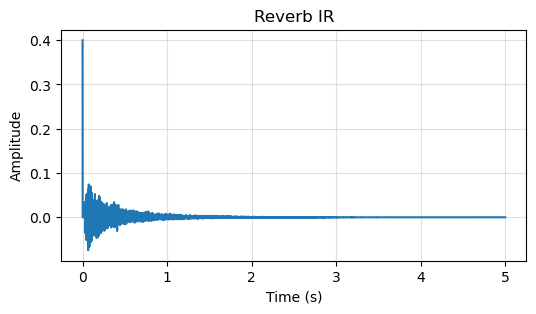

In [18]:
ir_signal = board(impulse_signal, samplerate)
plot_audio(ir_signal, samplerate, '{} IR'.format(fx_name))
Audio(data=ir_signal, rate=samplerate)

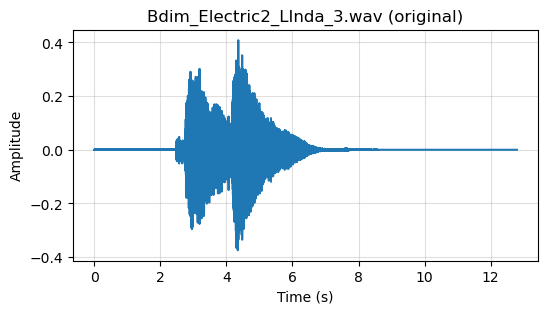

In [19]:
y, __, filepath = get_random_audio(lst_audio_paths)
plot_audio(y, samplerate, '{} (original)'.format(filepath.name))
Audio(data=y, rate=samplerate)

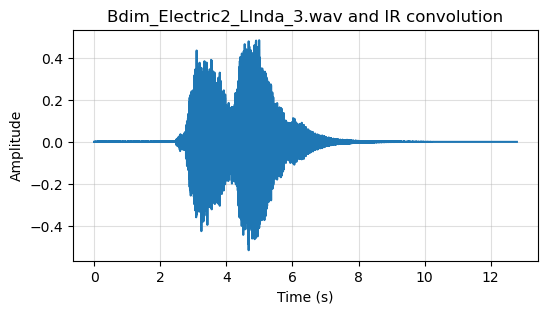

In [20]:
convolution_signal = np.convolve(y, ir_signal, mode='full')[:len(y)]
plot_audio(convolution_signal, samplerate, '{} and IR convolution'.format(filepath.name))
Audio(data=convolution_signal, rate=samplerate)

### Generating impulse response and convolutions to each effect

In [21]:
def generate_ir_and_convulute(
    fx_name,
    board,
    impulse_signal, 
    samplerate,
    pcm,
    output_dataset_path,
    lst_audio_paths,
    impulse_wav_filename
):
    ir_signal = board(impulse_signal.copy(), samplerate)
    sf.write(output_dataset_path/impulse_wav_filename.format(fx_name), ir_signal, samplerate, pcm)
    
    output_dir = output_dataset_path/fx_name
    if not output_dir.is_dir():
        output_dir.mkdir()
    
    for filepath in lst_audio_paths:
        with AudioFile(str(filepath)) as f:
            audio_signal = f.read(f.frames)
        convolution_signal = np.convolve(np.squeeze(audio_signal), ir_signal, mode='full')[:len(audio_signal)]
        sf.write(output_dir/filepath.name, convolution_signal, samplerate, pcm)

In [22]:
impulse_wav_filename = '{}_impulse_response.wav'
impulse_duration_sec = 5
impulse_signal       = signal.unit_impulse(samplerate * impulse_duration_sec)

for fx_name, params in fx_parameters['fx'].items():
    
    print('{}...'.format(fx_name), end=' ')

    board     = Pedalboard([eval(fx_name)(**params)])
    ir_signal = board(impulse_signal.copy(), samplerate)
    sf.write(output_dataset_path/impulse_wav_filename.format(fx_name), ir_signal, samplerate, pcm)
    
    output_dir = output_dataset_path/fx_name
    if not output_dir.is_dir():
        output_dir.mkdir()
    
    for filepath in lst_audio_paths:
        with AudioFile(str(filepath)) as f:
            audio_signal = f.read(f.frames)
        convolution_signal = np.convolve(np.squeeze(audio_signal), ir_signal, mode='full')[:len(audio_signal)]
        sf.write(output_dir/filepath.name, convolution_signal, samplerate, pcm)
        
    print('OK')

Compressor... OK
Chorus... OK
Distortion... OK
Reverb... OK
LowpassFilter... OK
HighpassFilter... OK
